In [6]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array

In [7]:

folder = '/data/Breast_cancer_cnn/data/BreaKHis_v1/histology_slides/breast/'
folder_path = pathlib.Path(folder)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x1DA6D1CF3D0>


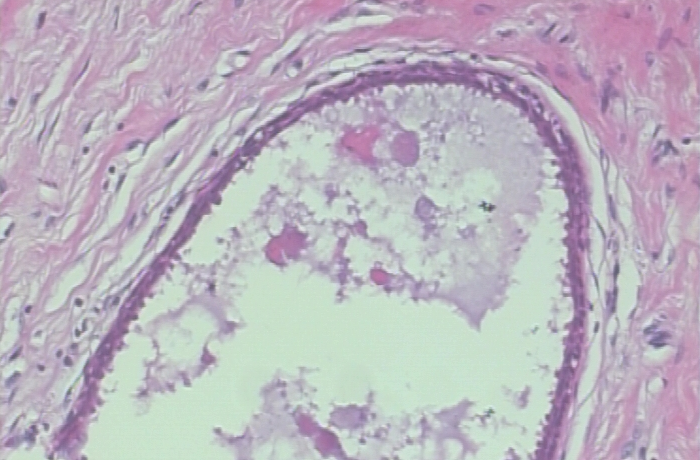

In [8]:

photo = load_img('/data/Breast_cancer_cnn/data/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png')
print(photo)
photo

In [9]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [10]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 7909 images belonging to 2 classes.


In [11]:
train_data, train_labels = train_data_gen.next()

In [12]:
#Synthetic Minority Over-sampling Technique
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(8040, 49152) (8040, 1)


In [13]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(8040, 128, 128, 3) (8040, 1)


In [14]:
train_labels = train_labels.reshape(-1, 1)

C:\Users\chwo6\AppData\Roaming\Python\Python38\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


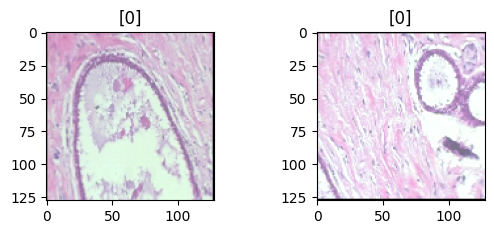

In [15]:
for i in range(2):
    plt.subplot(2,2,1+i)
    plt.title(train_labels[i])
    plt.imshow(train_data[i])

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [18]:
from keras.layers import MaxPool2D


act = 'relu'
IMAGE_SIZE = (128, 128)

cnn_model = Sequential([
Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
Conv2D(16, 3, activation=act, padding='same'),
Conv2D(16, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(32, 3, activation=act, padding='same'),
Conv2D(32, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
BatchNormalization(),
    MaxPool2D(),
Dropout(0.2),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Flatten(),
Dense(512, activation=act),
BatchNormalization(),
Dropout(0.7),
Dense(128, activation=act),
BatchNormalization(),
Dropout(0.5),
Dense(64, activation=act),
BatchNormalization(),
Dropout(0.3),
Dense(1, activation='sigmoid')
], name='cnn_model')

In [19]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        92

In [20]:
plot_model(cnn_model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
tf.keras.backend.set_image_data_format('channels_first')

In [52]:
# Fit the model to the training data
history = cnn_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
cnn_accuracy_history = history.history['accuracy']
cnn_loss_history = history.history['loss']


cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train your model (you should have a trained model)

# Save the model to a file
cnn_model.save('my_cnn_model.h5')

NameError: name 'validation_data' is not defined

In [54]:
from tensorflow.keras.models import load_model
loaded_model = load_model(r'E:\data\Breast_cancer_cnn\my_cnn_model.h5') 

In [55]:
loaded_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        92

In [23]:
loss, accuracy = cnn_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 1s 9ms/step - loss: 0.2697 - accuracy: 0.8993
Accuracy: 89.93%


In [24]:
y_pred = np.round(cnn_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

cnn_precision = avg_precision
cnn_recall = avg_recall
cnn_f1score = avg_f1_score

Average Precision: 90.50%
Average Recall: 89.93%
Average F1 Score: 89.90%


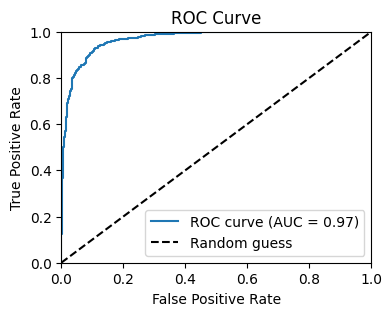

In [25]:
# Get predicted probabilities for test set
y_pred_prob = cnn_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

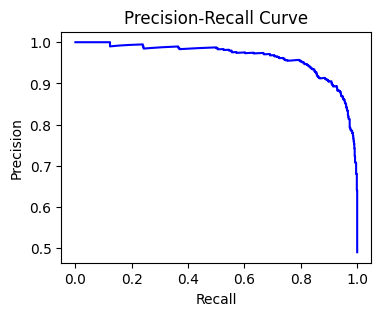

In [26]:
y_scores = cnn_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

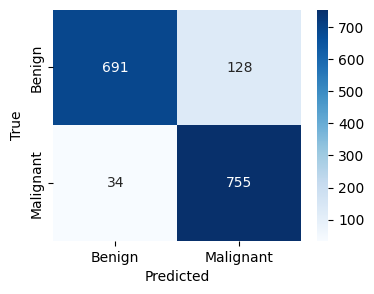

In [27]:
# your code here
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
from keras import backend as K

K.set_image_data_format('channels_last')
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [29]:
for layer in vgg_model.layers:
    layer.trainable = False

In [30]:
vgg16_model = Sequential([
    vgg_model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')        
], name="vgg16_model")

In [31]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 512)               

In [32]:
plot_model(vgg16_model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [33]:
# Fit the model to the training data
vgg16_history = vgg16_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
vgg16_accuracy_history = vgg16_history.history['accuracy']
vgg16_loss_history = vgg16_history.history['loss']

Epoch 1/50
161/161 [==============================] - 6s 26ms/step - loss: 0.7446 - accuracy: 0.5782
Epoch 2/50
161/161 [==============================] - 4s 24ms/step - loss: 0.5529 - accuracy: 0.7199
Epoch 3/50
161/161 [==============================] - 4s 23ms/step - loss: 0.4335 - accuracy: 0.8064
Epoch 4/50
161/161 [==============================] - 4s 24ms/step - loss: 0.3724 - accuracy: 0.8371
Epoch 5/50
161/161 [==============================] - 4s 24ms/step - loss: 0.3054 - accuracy: 0.8721
Epoch 6/50
161/161 [==============================] - 4s 23ms/step - loss: 0.2836 - accuracy: 0.8853
Epoch 7/50
161/161 [==============================] - 4s 23ms/step - loss: 0.2273 - accuracy: 0.9052
Epoch 8/50
161/161 [==============================] - 4s 23ms/step - loss: 0.2100 - accuracy: 0.9193
Epoch 9/50
161/161 [==============================] - 4s 23ms/step - loss: 0.1869 - accuracy: 0.9277
Epoch 10/50
161/161 [==============================] - 4s 23ms/step - loss: 0.1932 - accura

In [34]:
loss, accuracy = vgg16_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 1s 22ms/step - loss: 0.5217 - accuracy: 0.8551
Accuracy: 85.51%


In [35]:
y_pred = np.round(vgg16_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

vgg16_precision = avg_precision
vgg16_recall = avg_recall
vgg16_f1score = avg_f1_score

Average Precision: 85.55%
Average Recall: 85.51%
Average F1 Score: 85.51%


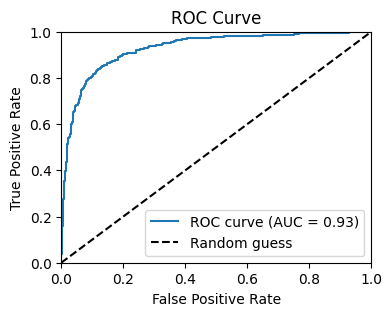

In [36]:
# Get predicted probabilities for test set
y_pred_prob_tl = vgg16_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob_tl)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob_tl)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

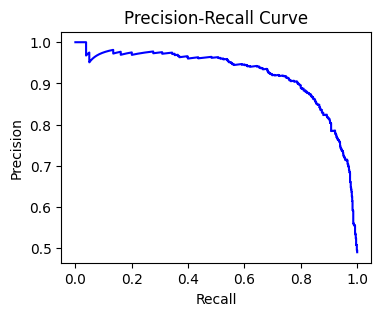

In [37]:
y_scores = vgg16_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [38]:
# Load the pre-trained ResNet50V2 model
resnet50v2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the layers in the pre-trained model
for layer in resnet50v2.layers:
    layer.trainable = False

94683136/94668760 [==============================] - 4s 0us/step


In [39]:
ResNet50V2_model = Sequential([
    resnet50v2,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="ResNet50V2_model")

In [40]:
ResNet50V2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ResNet50V2_model.summary()

Model: "ResNet50V2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               16777728  
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                  

In [41]:
plot_model(ResNet50V2_model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [42]:
ResNet50V2_model_history = ResNet50V2_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
ResNet_accuracy_history = ResNet50V2_model_history.history['accuracy']
ResNet_loss_history = ResNet50V2_model_history.history['loss']

Epoch 1/50
161/161 [==============================] - 7s 29ms/step - loss: 0.6050 - accuracy: 0.7397
Epoch 2/50
161/161 [==============================] - 4s 28ms/step - loss: 0.3597 - accuracy: 0.8468
Epoch 3/50
161/161 [==============================] - 4s 27ms/step - loss: 0.2571 - accuracy: 0.8925
Epoch 4/50
161/161 [==============================] - 4s 27ms/step - loss: 0.1994 - accuracy: 0.9211
Epoch 5/50
161/161 [==============================] - 4s 27ms/step - loss: 0.1620 - accuracy: 0.9347
Epoch 6/50
161/161 [==============================] - 4s 27ms/step - loss: 0.1348 - accuracy: 0.9485
Epoch 7/50
161/161 [==============================] - 4s 27ms/step - loss: 0.1131 - accuracy: 0.9543
Epoch 8/50
161/161 [==============================] - 4s 27ms/step - loss: 0.0962 - accuracy: 0.9637
Epoch 9/50
161/161 [==============================] - 4s 27ms/step - loss: 0.0972 - accuracy: 0.9623
Epoch 10/50
161/161 [==============================] - 4s 28ms/step - loss: 0.0838 - accura

In [43]:
loss, accuracy = ResNet50V2_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 2s 27ms/step - loss: 0.6942 - accuracy: 0.8520
Accuracy: 85.20%


In [44]:
y_pred = np.round(ResNet50V2_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

ResNet_precision = avg_precision
ResNet_recall = avg_recall
ResNet_f1score = avg_f1_score

Average Precision: 85.21%
Average Recall: 85.20%
Average F1 Score: 85.20%


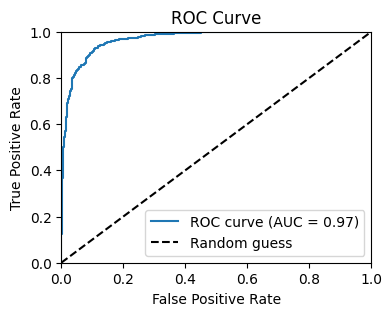

In [45]:
# Get predicted probabilities for test set
y_pred = ResNet50V2_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

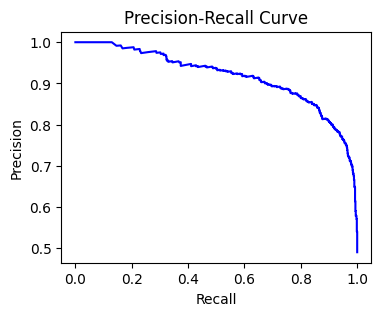

In [46]:
y_scores = ResNet50V2_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#  **Model Evaluation**

In [47]:
# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_data, test_labels)

# Evaluate the VGG16 model
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_data, test_labels)

# Evaluate the ResNet50V2 model
resnet_loss, resnet_accuracy = ResNet50V2_model.evaluate(test_data, test_labels)

print('+-------------------------------------------------------+')
print('|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |')
print('+-----------------+---------------+---------------------+')
print(f'|    {"CNN Model":<15} |    {cnn_loss:.2f}      |        {cnn_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'|   {"VGG16 Model":<15} |    {vgg16_loss:.2f}      |        {vgg16_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'| {"ResNet50V2 Model":<15} |    {resnet_loss:.2f}      |        {resnet_accuracy:.2f}         |')
print('+-----------------+---------------+---------------------+')


51/51 [==============================] - 1s 22ms/step - loss: 0.6942 - accuracy: 0.8520
+-------------------------------------------------------+
|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |
+-----------------+---------------+---------------------+
|    CNN Model       |    0.27      |        0.90        |
+-----------------+---------------+---------------------+
|   VGG16 Model     |    0.52      |        0.86        |
+-----------------+---------------+---------------------+
| ResNet50V2 Model |    0.69      |        0.85         |
+-----------------+---------------+---------------------+


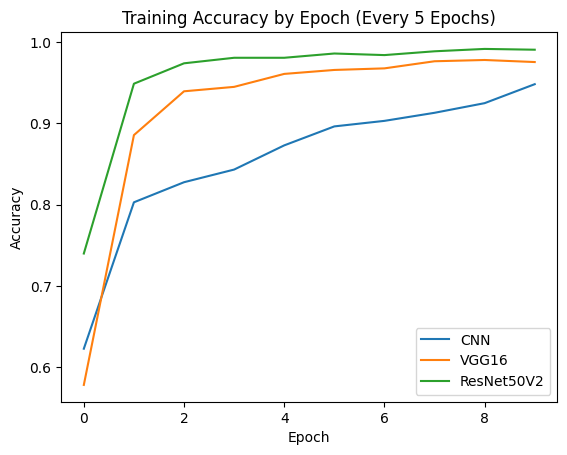

In [48]:
# Extract the accuracy history for each model every 5 epochs
cnn_history = cnn_accuracy_history[::5]
vgg16_history = vgg16_accuracy_history[::5]
resnet_history = ResNet_accuracy_history[::5]

# Plot the accuracy history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Accuracy by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

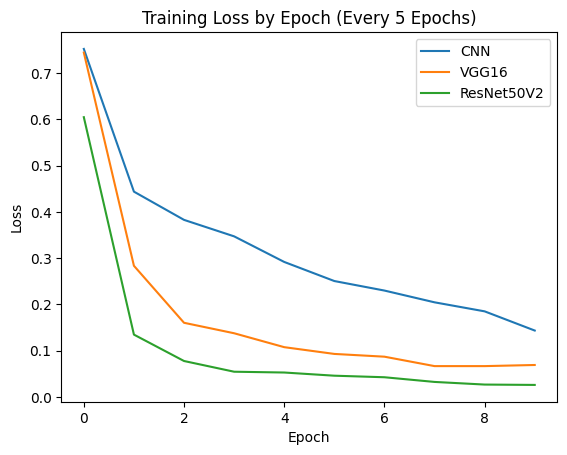

In [49]:
# Extract the loss history for each model every 5 epochs
cnn_history = cnn_loss_history[::5]
vgg16_history = vgg16_loss_history[::5]
resnet_history = ResNet_loss_history[::5]

# Plot the loss history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Loss by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [50]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Model': ['CNN', 'VGG16', 'ResNet50V2'],
   'Avg Precision': [cnn_precision*100, vgg16_precision*100, ResNet_precision*100],
        'Avg Recall': [cnn_recall*100, vgg16_recall*100, ResNet_recall*100],
        'Avg F1-Score': [cnn_f1score*100, vgg16_f1score*100, ResNet_f1score*100]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Print the DataFrame
print(metrics_df)

        Model  Avg Precision  Avg Recall  Avg F1-Score
0         CNN      90.498632   89.925373     89.901896
1       VGG16      85.546747   85.509950     85.510853
2  ResNet50V2      85.210968   85.199005     85.200242


In [65]:

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# 모델 불러오기
model = tf.keras.models.load_model('./my_cnn_model.h5')

# 이미지 파일 경로
image_path = r'E:\data\Breast_cancer_cnn\data\BreaKHis_v1\histology_slides\breast\benign\SOB\fibroadenoma\SOB_B_F_14-14134\40X\SOB_B_F-14-14134-40-002.png'

# 이미지 파일 읽기
img = image.load_img(image_path, target_size=(128, 128))  # 이미지 크기를 모델의 입력 크기와 일치하도록 조정
img_array = image.img_to_array(img)  # 이미지를 NumPy 배열로 변환
img_array = np.expand_dims(img_array, axis=0)  # 모델의 예상 입력 형태로 차원 확장 (batch 차원 추가)

# 전처리 (예시: 이미지를 0~1 범위로 정규화)
img_array /= 255.0

# 예측 수행
predictions = model.predict(img_array)

if predictions <= 0.4:
    result = "정상"
else:
    result = "암"

print("결과:", result)

결과: 정상


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# 모델 불러오기
model = tf.keras.models.load_model('my_cnn_model.h5')

# 이미지 파일 경로
image_path = r'E:\data\Breast_cancer_cnn\data\BreaKHis_v1\histology_slides\breast\malignant\SOB\ductal_carcinoma\SOB_M_DC_14-2523\40X\SOB_M_DC-14-2523-40-010.png'

# 이미지 파일 읽기
img = image.load_img(image_path, target_size=(128, 128))  # 이미지 크기를 모델의 입력 크기와 일치하도록 조정
img_array = image.img_to_array(img)  # 이미지를 NumPy 배열로 변환
img_array = np.expand_dims(img_array, axis=0)  # 모델의 예상 입력 형태로 차원 확장 (batch 차원 추가)

# 전처리 (예시: 이미지를 0~1 범위로 정규화)
img_array /= 255.0

# 예측 수행
predictions = model.predict(img_array)

# 예측 결과 출력
print(predictions)


[[0.9999988]]


In [66]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        92

In [58]:
# 모델에 데이터를 입력하고 예측을 수행합니다.
# 예측 결과는 클래스별 확률 또는 레이블일 수 있습니다.
predictions = loaded_model.predict(prepared_data)
# 예측 결과를 해석하여 출력합니다. 이 예제에서는 클래스 레이블을 출력합니다.
# 각 클래스에 대한 확률을 얻고 가장 높은 확률을 가진 클래스를 선택할 수도 있습니다.
predicted_label = decode_predictions(predictions, top=1)[0]
print("예측 결과:", predicted_label)


IndexError: list index out of range